# **Case Background**

Aachen is one of the top 10 city in Germany with the most number of college students. Aachen also have a lot of international students who has just come to Germany. Therefore they need to look for pace to rent. The purpose of this case study is to help making some guidance for basic data about renting in Aachen, before they survey further for details based on their own needs and preferences. The conclusion will summarize about three things:


*   How much is the usual cost rent in Aachen
*   What number of rooms will be more efficient cost-wise
*   What are the cost rate for each district around Aachen and what are the facilities around those districts





## **Step 1: Gathering the Data**

We will collect the apartment data from local website. First, we determine the library we need for this analysis.

In [ ]:
import pandas as pd
import numpy as np

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.distance import great_circle

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import json # library to handle JSON files

import requests # library to handle requests
from requests import get

import bs4 #library to web scrapping for the data
from bs4 import BeautifulSoup

import re #library to clean some data
from re import sub

from time import sleep

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import seaborn as sns

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

baseurl = 'https://www.immonet.de'

headers = {
           'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
          }

Afterwards, we need to web scrapping the data from the local apartment site. Here we use www.immonet.de for those, also we give the limit radius here to 15 km, so the apartments distance are not too far from the central of Aachen.

In [ ]:
wohnunglinks = []

for x in range (1,15):
  r = requests.get(f'https://www.immonet.de/immobiliensuche/sel.do?longitude=6.091431609012505&suchart=2&city=82223&marketingtype=2&pageoffset=378&radius=15&parentcat=1&listsize=27&latitude=50.761371769897195&sortby=16&objecttype=1&district=7303&page={x}', headers=headers)
  sp = bs4.BeautifulSoup(r.text, 'html.parser')
  liste = sp.find_all('div', class_="flex-grow-1 display-flex-sm")

  for wohnung in liste:
    for link in wohnung.find_all('a', href=True):
      wohnunglinks.append(baseurl + link['href'])

print('Number of Apartment Data Listed:')
print(len(wohnunglinks))

Number of Apartment Data Listed:
374


We create a database for the apartment links we have found.

In [ ]:
wohnungliste = []
for link in wohnunglinks:
  req = requests.get(link, headers=headers)
  soup = bs4.BeautifulSoup(req.text, 'html.parser')

  txt = soup.find('p', class_="text-100 pull-left")
  ls = list(txt.stripped_strings)
  if ((ls[0])[0].isdigit()) == True:
    address = list(txt.stripped_strings)[0].split('\xa0\n\t\t\t\t\t\t')
  else:
    address = list(txt.stripped_strings)[1].split('\xa0\n\t\t\t\t\t\t')
  if (len(soup.find_all('span', class_="align-self-flex-end text-primary-highlight text-250"))) == 1:
    rooms = 1
  else:
    rooms = soup.find_all('span', class_="align-self-flex-end text-primary-highlight text-250")[1].text.strip()

  name = soup.find('h1', class_="headline-250 line-height-normal").text.strip()
  postalcode = address[0]
  district = address[1]
  coldprice = re.sub(r'[€]',r'', soup.find('span', class_="align-self-flex-end text-250 text-primary-highlight").text.strip() ).replace(u'\xa0', u'')
  area = re.sub(r'[m|²]',r'', soup.find_all('span', class_="align-self-flex-end text-primary-highlight text-250")[0].text.strip() ).replace(u'\xa0', u'')

  wohnung = {
  'Name' : name, 
  'PostalCode' : postalcode,
  'District' : district,
  'Coldprice' : coldprice,
  'Area' : area,
  'Rooms' : rooms,
   }

  wohnungliste.append(wohnung)
  # set sleep to mimic a more human behaviour and don't overload the site with requests
  sleep(np.random.randint(1,3))

rental_properties = pd.DataFrame(wohnungliste)
print('Dimensions of the DataFrame :')
print(rental_properties.shape)

Dimensions of the DataFrame :
(374, 6)


In [ ]:
rental_data = rental_properties[['PostalCode','District','Coldprice','Area','Rooms']].drop_duplicates().sort_values(by=['PostalCode']).reset_index(drop=True)
rental_data.head()

,PostalCode,District,Coldprice,Area,Rooms
0,52062,Aachen,590.0,47.58,1.0
1,52062,Aachen,545.0,64.0,2.0
2,52062,Aachen,503.5,53.0,2.0
3,52062,Aachen,1399.48,101.87,3.0
4,52062,Aachen,1180.0,115.0,4.0


From the website, we get the address data, coldprice/kaltmiete (in Euro), area (in square metre), and number of rooms.

## **Step 2: Pre-process and Analyze the Data**

Adjust the data so they have the same format for each column.

In [ ]:
rental_data['Area'] = rental_data['Area'].astype('float')
rental_data['Rooms'] = rental_data['Rooms'].astype('float')
rental_data['Coldprice'] = rental_data['Coldprice'].str.replace('auf Anfrage', 'NaN').astype('float')

And then we remove the rows with N/A values.

In [ ]:
rental_data.dropna(subset=['PostalCode', 'District', 'Coldprice', 'Area', 'Rooms'], inplace=True)
print('There are {} apartments in the dataset'.format(rental_data.shape[0]))

There are 344 apartments in the dataset


For our analysis, we add the "coldprice/m2" column.

In [ ]:
rental_data['Coldprice/m2'] = (rental_data['Coldprice']/rental_data['Area']).round(2)
rental_data.head()

,PostalCode,District,Coldprice,Area,Rooms,Coldprice/m2
0,52062,Aachen,590.00,47.58,1.0,12.40
1,52062,Aachen,545.00,64.00,2.0,8.52
2,52062,Aachen,503.50,53.00,2.0,9.50
3,52062,Aachen,1399.48,101.87,3.0,13.74
4,52062,Aachen,1180.00,115.00,4.0,10.26


Also, we add the "coldprice/room" column.

In [ ]:
rental_data.dropna(subset=['PostalCode', 'District', 'Coldprice','Area', 'Rooms', 'Coldprice/m2'], inplace=True)
rental_data['Coldprice/room'] = (rental_data['Coldprice']/rental_data['Rooms']).round(2)
rental_data.head()

,PostalCode,District,Coldprice,Area,Rooms,Coldprice/m2,Coldprice/room
0,52062,Aachen,590.00,47.58,1.0,12.40,590.00
1,52062,Aachen,545.00,64.00,2.0,8.52,272.50
2,52062,Aachen,503.50,53.00,2.0,9.50,251.75
3,52062,Aachen,1399.48,101.87,3.0,13.74,466.49
4,52062,Aachen,1180.00,115.00,4.0,10.26,295.00


Here is the dataframe description.

In [ ]:
rental_data.describe()

,Coldprice,Area,Rooms,Coldprice/m2,Coldprice/room
count,344.000000,344.000000,344.000000,344.000000,344.000000
mean,674.991831,65.393547,2.292151,11.077674,319.257529
std,318.449874,29.563325,0.974737,3.568296,140.339787
min,199.000000,13.000000,1.000000,4.760000,100.000000
25%,449.000000,45.000000,2.000000,8.515000,224.442500
50%,600.000000,64.000000,2.000000,10.070000,291.775000
75%,816.285000,83.250000,3.000000,12.420000,374.140000
max,2250.000000,200.000000,5.000000,26.940000,1399.000000


From here, we can see that the mean price for the properties around Aachen:


*   Coldprice: 674.99 €
*   Coldprice/m2: 11.07 €
*   Coldprice/room: 319.25 €

These numbers can be the first guidelines for student to know the rent cost rate around Aachen. We will break this down one by one further below.



First, we will break this down for each district to see which district has the cheapest rate.

In [ ]:
rental_data_counts = rental_data['District'].value_counts().sort_index().reset_index()
mean_per_district = rental_data[['District','Coldprice','Area','Rooms','Coldprice/m2','Coldprice/room']].groupby('District').mean().reset_index()
mean_per_district['DataEachDistrict'] = rental_data_counts['District']
mean_per_district

,District,Coldprice,Area,Rooms,Coldprice/m2,Coldprice/room,DataEachDistrict
0,Aachen,667.373880,60.944520,2.114000,11.916040,343.406120,250
1,Alsdorf,1030.115625,92.080625,3.656250,10.848750,276.605625,16
2,Eschweiler,540.993000,66.295333,2.416667,8.259000,233.679667,30
3,Herzogenrath,655.000000,82.633333,2.916667,7.663333,225.750000,6
4,Roetgen,632.000000,58.000000,2.000000,10.900000,316.000000,1
5,Stolberg,646.791667,78.146250,2.604167,8.360417,260.473750,24
6,Würselen,738.651765,80.458235,2.764706,8.990000,271.477059,17


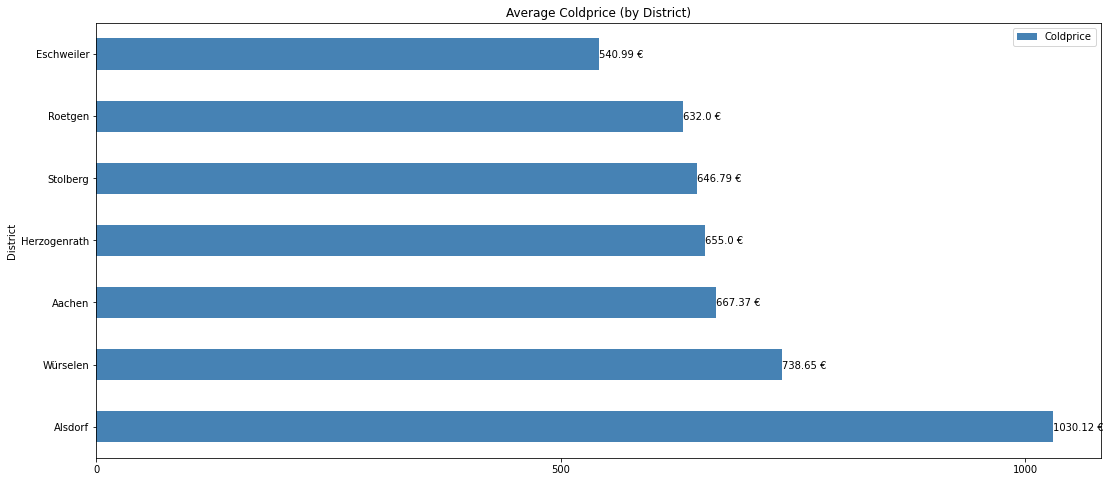

In [ ]:
mean_per_district.sort_values('Coldprice', inplace=True)
cd_plot = mean_per_district.plot(x='District', y='Coldprice', title='Average Coldprice (by District)', kind='barh', figsize=(18, 8), color='steelblue')
cd_plot.set_xticks([0, 500, 1000])

# set individual bar lables using above list
for i in cd_plot.patches:
    # get_width pulls left or right; get_y pushes up or down
    cd_plot.text(i.get_width()+.1, i.get_y()+.31, \
            str(round((i.get_width()), 2))+' €', fontsize=10, color='black')

# invert for largest on top 
cd_plot.invert_yaxis()

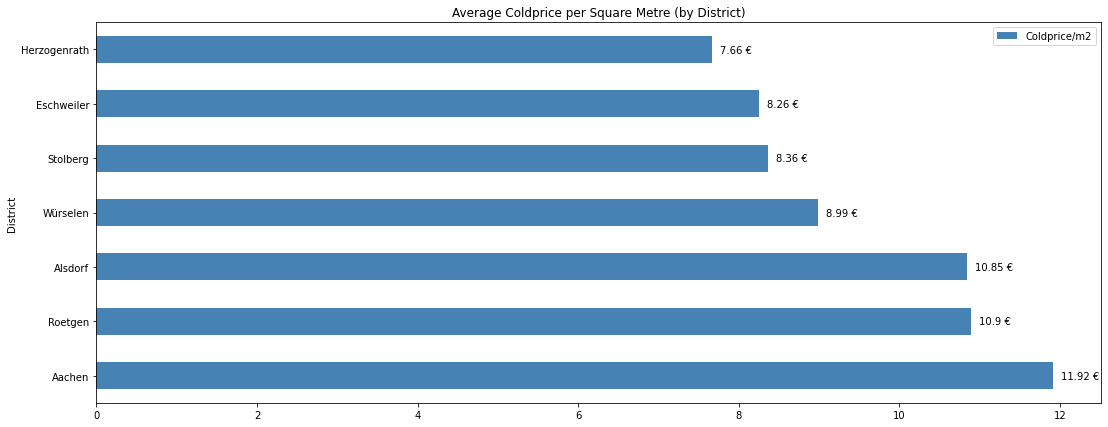

In [ ]:
mean_per_district.sort_values('Coldprice/m2', inplace=True)
cdm_plot = mean_per_district.plot(x='District', y='Coldprice/m2', title='Average Coldprice per Square Metre (by District)', kind='barh', figsize=(18, 7), color='steelblue')

# set individual bar lables using above list
for i in cdm_plot.patches:
    # get_width pulls left or right; get_y pushes up or down
    cdm_plot.text(i.get_width()+.1, i.get_y()+.31, \
            str(round((i.get_width()), 2))+' €', fontsize=10, color='black')

# invert for largest on top 
cdm_plot.invert_yaxis()

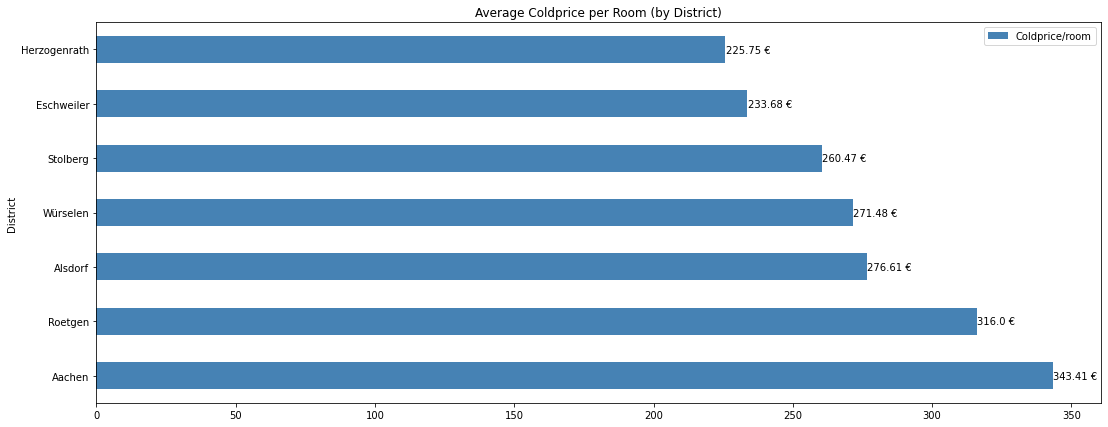

In [ ]:
mean_per_district.sort_values('Coldprice/room', inplace=True)
cdr_plot = mean_per_district.plot(x='District', y='Coldprice/room', title='Average Coldprice per Room (by District)', kind='barh', figsize=(18, 7), color='steelblue')

# set individual bar lables using above list
for i in cdr_plot.patches:
    # get_width pulls left or right; get_y pushes up or down
    cdr_plot.text(i.get_width()+.1, i.get_y()+.31, \
            str(round((i.get_width()), 2))+' €', fontsize=10, color='black')

# invert for largest on top 
cdr_plot.invert_yaxis()

From the table and the graphics above, we can see that from cold price, cold price per square metre, and cold price per amount of room aspects, **Eschweiler** comes first as the overall cheapest district. Followed by **Stolberg** in second.

The data also have quite good amount of samples for representation (around 10% from the total sample). So this analysis is quite valid.

## But what if you want to know the rates for each number of room categories?

As what we have done above, we will categorize the "rental data" table first by their number of rooms. And then we will make the bar graph.

In [ ]:
rental_data_rooms = rental_data['Rooms'].value_counts().sort_index().reset_index()
mean_per_rooms = rental_data[['District','Coldprice','Area','Rooms','Coldprice/m2','Coldprice/room']].groupby('Rooms').mean().reset_index()
mean_per_rooms['Samples'] = rental_data_rooms['Rooms']
mean_per_rooms

,Rooms,Coldprice,Area,Coldprice/m2,Coldprice/room,Samples
0,1.0,430.442195,32.038049,14.791707,430.442195,82
1,1.5,476.666667,54.666667,8.916667,317.776667,3
2,2.0,633.961316,59.932982,10.586754,316.980702,114
3,2.5,558.317500,66.387500,8.015000,223.327500,4
4,3.0,760.723786,82.783592,9.160971,253.574563,103
5,3.5,649.595000,71.375000,9.225000,185.600000,2
6,4.0,1121.280312,106.802500,10.275625,280.320000,32
7,5.0,1357.840000,129.802500,10.312500,271.567500,4


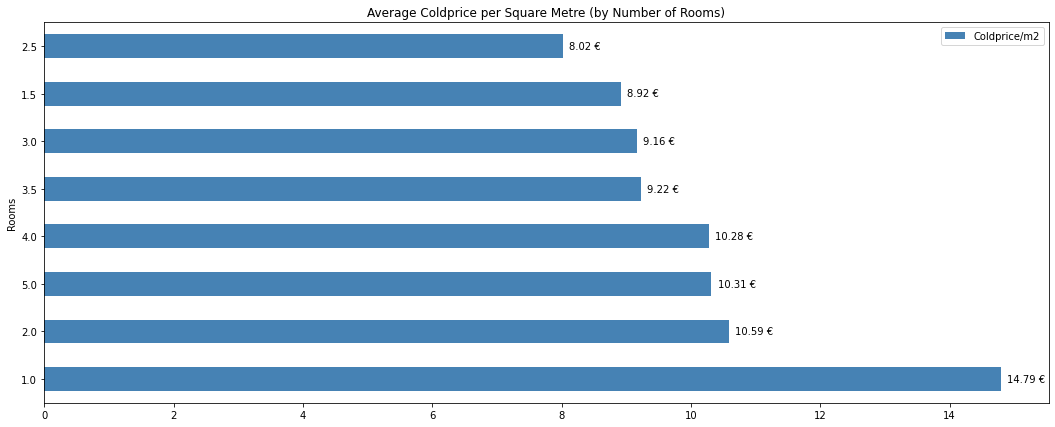

In [ ]:
mean_per_rooms.sort_values('Coldprice/m2', inplace=True)
crm_plot = mean_per_rooms.plot(x='Rooms', y='Coldprice/m2', title='Average Coldprice per Square Metre (by Number of Rooms)', kind='barh', figsize=(18, 7), color='steelblue')

# set individual bar lables using above list
for i in crm_plot.patches:
    # get_width pulls left or right; get_y pushes up or down
    crm_plot.text(i.get_width()+.1, i.get_y()+.31, \
            str(round((i.get_width()), 2))+' €', fontsize=10, color='black')

# invert for largest on top 
crm_plot.invert_yaxis()

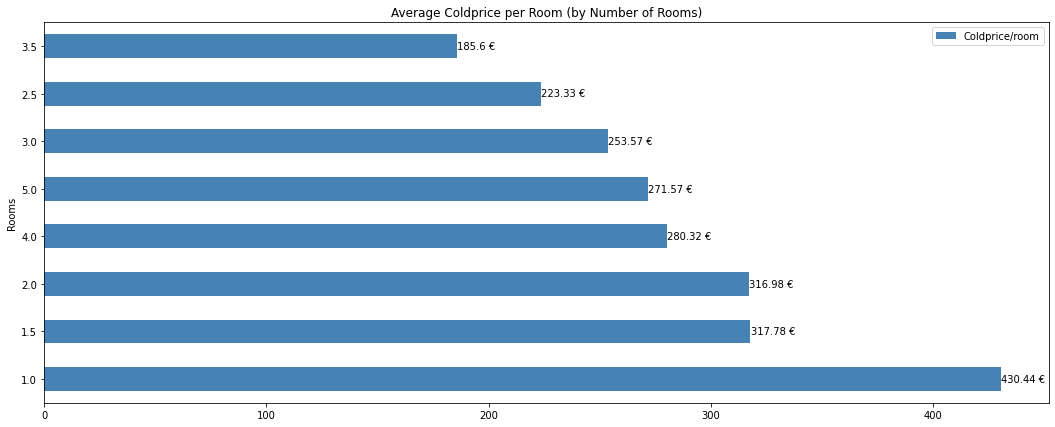

In [ ]:
mean_per_rooms.sort_values('Coldprice/room', inplace=True)
crr_plot = mean_per_rooms.plot(x='Rooms', y='Coldprice/room', title='Average Coldprice per Room (by Number of Rooms)', kind='barh', figsize=(18, 7), color='steelblue')

# set individual bar lables using above list
for i in crr_plot.patches:
    # get_width pulls left or right; get_y pushes up or down
    crr_plot.text(i.get_width()+.1, i.get_y()+.31, \
            str(round((i.get_width()), 2))+' €', fontsize=10, color='black')

# invert for largest on top 
crr_plot.invert_yaxis()

If we look at the graphs, the 3,5 and 2,5 rooms apartment seems to come as the cheapest option. But there is too few sample numbers from them (<5), so we are not quite sure whether this is valid analysis or not.

Meanwhile, the **3 room apartments** come close to them, and also with much more number of samples (around 30% of the total samples). So we can say that this is the cheapest number of apartment rooms option around Aachen.

## **Step 3: Visualize the district coordinates to search for facilities around each district**

First, we sort the address we have got from the samples.

In [ ]:
aachen_districts = rental_data[['PostalCode','District']].drop_duplicates().sort_values(by=['PostalCode']).reset_index(drop=True)
aachen_districts

,PostalCode,District
0,52062,Aachen
1,52064,Aachen
2,52066,Aachen
3,52068,Aachen
4,52070,Aachen
5,52072,Aachen
6,52074,Aachen
7,52076,Aachen
8,52078,Aachen
9,52080,Aachen


Then, we create a database of latitude and longitude of each postal code.

In [ ]:
aachen_postalcodes = pd.read_csv('Aachen_Postalcodes.csv').sort_values(by=['PostalCode']).reset_index(drop=True)
aachen_postalcodes

,PostalCode,Latitude,Longitude
0,52062,50.7760,6.0872
1,52064,50.7683,6.0760
2,52066,50.7564,6.0914
3,52068,50.7787,6.1084
4,52070,50.7884,6.1044
5,52072,50.8034,6.0627
6,52074,50.7479,6.0486
7,52076,50.7167,6.1481
8,52078,50.7624,6.1380
9,52080,50.7793,6.1642


We merge them into one database so we can visualize each postal code in a Folium map.

In [ ]:
district_coordinates = aachen_districts
district_coordinates['Latitude'] = aachen_postalcodes['Latitude']
district_coordinates['Longitude'] = aachen_postalcodes['Longitude']
district_coordinates

,PostalCode,District,Latitude,Longitude
0,52062,Aachen,50.7760,6.0872
1,52064,Aachen,50.7683,6.0760
2,52066,Aachen,50.7564,6.0914
3,52068,Aachen,50.7787,6.1084
4,52070,Aachen,50.7884,6.1044
5,52072,Aachen,50.8034,6.0627
6,52074,Aachen,50.7479,6.0486
7,52076,Aachen,50.7167,6.1481
8,52078,Aachen,50.7624,6.1380
9,52080,Aachen,50.7793,6.1642


We visualize each postal code in Folium map.

In [ ]:
# create map of Aachen using latitude and longitude values
map_aachen = folium.Map(location=[50.7800778,6.0634982], zoom_start=11)

# add markers to map
for lat, lng, postalcode, district in zip(district_coordinates['Latitude'], district_coordinates['Longitude'], district_coordinates['PostalCode'], district_coordinates['District']):
    label = '{}, {}'.format(postalcode, district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_aachen)  
    
map_aachen

As we have analyzed from the dataframe above, we have mentioned that **Eschweiler** and **Stolberg** are the two cheapest apartment place around Aachen. From this map, we can see that **Eschweiler** district has the shorter distance to the center of Aachen, around 1 hour using public transport. Meanwhile, **Stolberg** takes 30 minutes more using public transport.

We then analyze each district facilities using Foursquare.

In [ ]:
#Define your Foursquare Credentials and Version

CLIENT_ID = '**INSERT YOUR FOURSQUARE ID HERE**' # your Foursquare ID
CLIENT_SECRET = '**INSERT YOUR FOURSQUARE SECRET HERE**' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Let's create a function to repeat the same process to all the districts in Aachen.

In [ ]:
def getNearbyVenues(postalcode, district, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for postcode, dis, lat, lng in zip(postalcode, district, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            postcode,
            dis, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode',
                  'District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

We then create the dataframe to list facilities around all of the districts within 3 km radius.

In [ ]:
aachen_venues = getNearbyVenues(postalcode=district_coordinates['PostalCode'],
                                district=district_coordinates['District'],
                                latitudes=district_coordinates['Latitude'],
                                longitudes=district_coordinates['Longitude'],
                                radius=3000, LIMIT=100)
aachen_venues.head()

,PostalCode,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,52062,Aachen,50.776,6.0872,Katschhof,50.775611,6.083909,Plaza
1,52062,Aachen,50.776,6.0872,INNSIDE Aachen,50.779503,6.088607,Hotel
2,52062,Aachen,50.776,6.0872,BURGERISTA,50.776384,6.084331,Burger Joint
3,52062,Aachen,50.776,6.0872,Ghorban Delikatessen Manufaktur,50.776016,6.084324,Deli / Bodega
4,52062,Aachen,50.776,6.0872,Nobis Printen,50.774577,6.084693,Bakery


In [ ]:
print('{} venues are collected'.format(aachen_venues.shape[0]))

868 venues are collected


In [ ]:
aachen_venues.groupby('District').count()

,PostalCode,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,,
Aachen,698,698,698,698,698,698,698
Alsdorf,18,18,18,18,18,18,18
Eschweiler,18,18,18,18,18,18,18
Herzogenrath,67,67,67,67,67,67,67
Roetgen,5,5,5,5,5,5,5
Stolberg,27,27,27,27,27,27,27
Würselen,35,35,35,35,35,35,35


Let's find out how many unique categories can be curated from all the returned venues.

In [ ]:
print('There are {} uniques categories.'.format(len(aachen_venues['Venue Category'].unique())))

There are 116 uniques categories.


In [ ]:
# one hot encoding
aachen_onehot = pd.get_dummies(aachen_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
aachen_onehot['PostalCode'] = aachen_venues['PostalCode']
aachen_onehot['District'] = aachen_venues['District'] 

# move neighborhood column to the first column
fixed_columns = [aachen_onehot.columns[-1]] + list(aachen_onehot.columns[:-1])
aachen_onehot = aachen_onehot[fixed_columns]

aachen_onehot.head()

,District,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Border Crossing,Bowling Alley,Burger Joint,Bus Station,Bus Stop,Business Service,Café,Candy Store,Castle,Chinese Restaurant,Chocolate Shop,City Hall,Clothing Store,Cocktail Bar,Coffee Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Drugstore,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flower Shop,Food & Drink Shop,...,Outlet Store,Park,Pet Café,Pet Store,Pizza Place,Playground,Plaza,Pool,Pub,Record Shop,Restaurant,Road,Sandwich Place,Scenic Lookout,Science Museum,Shipping Store,Shoe Store,Shopping Mall,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Spa,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Thai Restaurant,Theater,Toy / Game Store,Track Stadium,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Wine Bar,Zoo,PostalCode
0,Aachen,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,52062
1,Aachen,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,52062
2,Aachen,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,52062
3,Aachen,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,52062
4,Aachen,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,52062


In [ ]:
aachen_onehot.shape

(868, 118)

Next, let's group rows by postal code and by taking the mean of the frequency of occurrence of each category.

In [ ]:
aachen_grouped = aachen_onehot.groupby('PostalCode').mean().reset_index()
aachen_grouped

,PostalCode,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Border Crossing,Bowling Alley,Burger Joint,Bus Station,Bus Stop,Business Service,Café,Candy Store,Castle,Chinese Restaurant,Chocolate Shop,City Hall,Clothing Store,Cocktail Bar,Coffee Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Drugstore,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flower Shop,Food & Drink Shop,...,Office,Outlet Store,Park,Pet Café,Pet Store,Pizza Place,Playground,Plaza,Pool,Pub,Record Shop,Restaurant,Road,Sandwich Place,Scenic Lookout,Science Museum,Shipping Store,Shoe Store,Shopping Mall,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Spa,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Thai Restaurant,Theater,Toy / Game Store,Track Stadium,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Wine Bar,Zoo
0,52062,0.000000,0.000000,0.010000,0.000000,0.000000,0.060000,0.000000,0.080000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.040000,0.01,0.000000,0.000000,0.010000,0.01,0.000000,0.02,0.020000,0.01,0.01,0.000000,0.01,0.000000,0.010000,0.000000,0.010000,0.000000,0.000000,0.000000,0.01,...,0.000000,0.010000,0.050000,0.01,0.000000,0.020000,0.000000,0.050000,0.010000,0.020000,0.000000,0.020000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.010000,0.00,0.01,0.010000,0.010000,0.050000,0.010000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.010000,0.01,0.010000,0.000000,0.01,0.010000
1,52064,0.000000,0.000000,0.010000,0.010000,0.000000,0.050000,0.000000,0.080000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.050000,0.01,0.000000,0.000000,0.010000,0.01,0.000000,0.02,0.020000,0.01,0.01,0.000000,0.01,0.000000,0.010000,0.000000,0.010000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.050000,0.01,0.000000,0.020000,0.000000,0.040000,0.020000,0.020000,0.010000,0.020000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.01,0.01,0.000000,0.010000,0.050000,0.010000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.030000,0.01,0.010000,0.000000,0.01,0.010000
2,52066,0.000000,0.000000,0.010000,0.010000,0.000000,0.050000,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.070000,0.01,0.000000,0.000000,0.000000,0.01,0.000000,0.02,0.020000,0.01,0.01,0.000000,0.01,0.000000,0.020000,0.000000,0.010000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.050000,0.01,0.000000,0.020000,0.000000,0.050000,0.020000,0.020000,0.010000,0.020000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.01,0.01,0.000000,0.010000,0.030000,0.010000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.050000,0.01,0.010000,0.000000,0.01,0.010000
3,52068,0.000000,0.000000,0.010000,0.000000,0.000000,0.060000,0.000000,0.080000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.040000,0.01,0.000000,0.000000,0.010000,0.01,0.000000,0.02,0.020000,0.01,0.01,0.000000,0.01,0.000000,0.020000,0.000000,0.020000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.010000,0.050000,0.01,0.000000,0.030000,0.000000,0.050000,0.010000,0.020000,0.000000,0.020000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.010000,0.00,0.01,0.010000,0.010000,0.040000,0.010000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.010000,0.01,0.010000,0.000000,0.01,0.010000
4,52070,0.000000,0.000000,0.010000,0.000000,0.000000,0.060000,0.000000,0.080000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.030000,0.01,0.000000,0.000000,0.010000,0.01,0.000000,0.02,0.010000,0.01,0.01,0.000000,0.01,0.000000,0.030000,0.000000,0.020000,0.000000

Let's write a function to sort the venues in descending order.

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create a new dataframe and display the top 10 venues for each district.

In [ ]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['PostalCode']
for idx in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(idx+1, indicators[idx]))
    except:
        columns.append('{}th Most Common Venue'.format(idx+1))

# create a new dataframe
district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['PostalCode'] = aachen_grouped['PostalCode']

for idx in np.arange(aachen_grouped.shape[0]):
    district_venues_sorted.iloc[idx, 1:] = return_most_common_venues(aachen_grouped.iloc[idx, :], num_top_venues)

district_venues_sorted.insert(1, 'District', district_coordinates['District'], True)
district_venues_sorted

,PostalCode,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,52062,Aachen,Bar,German Restaurant,Bakery,Plaza,Supermarket,Park,Italian Restaurant,Ice Cream Shop,Café,Music Venue
1,52064,Aachen,Bar,German Restaurant,Park,Bakery,Café,Supermarket,Ice Cream Shop,Italian Restaurant,Plaza,Turkish Restaurant
2,52066,Aachen,Bar,Café,German Restaurant,Bakery,Turkish Restaurant,Italian Restaurant,Plaza,Park,Ice Cream Shop,Music Venue
3,52068,Aachen,Bar,Bakery,Park,Plaza,Italian Restaurant,German Restaurant,Ice Cream Shop,Supermarket,Café,Pizza Place
4,52070,Aachen,Bar,Bakery,Plaza,Supermarket,Italian Restaurant,Park,German Restaurant,Ice Cream Shop,Café,Drugstore
5,52072,Aachen,Supermarket,Hotel,Liquor Store,Outlet Store,Gym,Business Service,Korean Restaurant,Restaurant,Road,Sandwich Place
6,52074,Aachen,Supermarket,Café,Restaurant,Pool,Scenic Lookout,German Restaurant,Forest,Park,Fast Food Restaurant,Pet Store
7,52076,Aachen,Supermarket,German Restaurant,Hotel,Bakery,Trail,Gas Station,Pizza Place,Ice Cream Shop,Gastropub,Restaurant
8,52078,Aachen,Supermarket,Bus Stop,Hotel,Turkish Restaurant,Bar,Ice Cream Shop,Gas Station,Plaza,Gourmet Shop,Greek Restaurant
9,52080,Aachen,Supermarket,Fast Food Restaurant,Bakery,Hotel,Bus Station,Greek Restaurant,Gastropub,Garden Center,Fried Chicken Joint,Drugstore


From this data, we can see the only difference between inside the center of Aachen and outside is that bar is the most common venue in the center of Aachen.

Other than that, these districts have pretty much the same common facilities, such as supermarket, restaurant, and public transport. So all district provide quite enough facilities for daily needs.

Then, we run k-means to cluster the districts into 2 clusters.

In [ ]:
# set number of clusters
kclusters = 2

aachen_grouped_clustering = aachen_grouped.drop(['PostalCode'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(aachen_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:17]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1], dtype=int32)

We create a new database consist of postal code, district, latitude and longitude (to be plotted to cluster map), and their most common venue.

In [ ]:
aachen_merged = district_venues_sorted
aachen_merged.insert(2, 'Cluster Labels', kmeans.labels_)

In [ ]:
aachen_merged.insert(3, 'Latitude', district_coordinates['Latitude'])

In [ ]:
aachen_merged.insert(4, 'Longitude', district_coordinates['Longitude'])

In [ ]:
aachen_merged

,PostalCode,District,Cluster Labels,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,52062,Aachen,1,50.7760,6.0872,Bar,German Restaurant,Bakery,Plaza,Supermarket,Park,Italian Restaurant,Ice Cream Shop,Café,Music Venue
1,52064,Aachen,1,50.7683,6.0760,Bar,German Restaurant,Park,Bakery,Café,Supermarket,Ice Cream Shop,Italian Restaurant,Plaza,Turkish Restaurant
2,52066,Aachen,1,50.7564,6.0914,Bar,Café,German Restaurant,Bakery,Turkish Restaurant,Italian Restaurant,Plaza,Park,Ice Cream Shop,Music Venue
3,52068,Aachen,1,50.7787,6.1084,Bar,Bakery,Park,Plaza,Italian Restaurant,German Restaurant,Ice Cream Shop,Supermarket,Café,Pizza Place
4,52070,Aachen,1,50.7884,6.1044,Bar,Bakery,Plaza,Supermarket,Italian Restaurant,Park,German Restaurant,Ice Cream Shop,Café,Drugstore
5,52072,Aachen,1,50.8034,6.0627,Supermarket,Hotel,Liquor Store,Outlet Store,Gym,Business Service,Korean Restaurant,Restaurant,Road,Sandwich Place
6,52074,Aachen,1,50.7479,6.0486,Supermarket,Café,Restaurant,Pool,Scenic Lookout,German Restaurant,Forest,Park,Fast Food Restaurant,Pet Store
7,52076,Aachen,1,50.7167,6.1481,Supermarket,German Restaurant,Hotel,Bakery,Trail,Gas Station,Pizza Place,Ice Cream Shop,Gastropub,Restaurant
8,52078,Aachen,1,50.7624,6.1380,Supermarket,Bus Stop,Hotel,Turkish Restaurant,Bar,Ice Cream Shop,Gas Station,Plaza,Gourmet Shop,Greek Restaurant
9,52080,Aachen,1,50.7793,6.1642,Supermarket,Fast Food Restaurant,Bakery,Hotel,Bus Station,Greek Restaurant,Gastropub,Garden Center,Fried Chicken Joint,Drugstore


We visualize each cluster in cluster map.

In [ ]:
# create map of Aachen using latitude and longitude values
map_clusters = folium.Map(location=[50.7800778,6.0634982], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(aachen_merged['Latitude'], aachen_merged['Longitude'], aachen_merged['District'], aachen_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [ ]:
cluster1 = aachen_merged.loc[aachen_merged['Cluster Labels'] == 0, aachen_merged.columns[[1] + list(range(5, aachen_merged.shape[1]))]]
cluster1

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Roetgen,Supermarket,Spa,Gas Station,Italian Restaurant,Fast Food Restaurant,French Restaurant,Forest,Food & Drink Shop,Flower Shop,Zoo
13,Stolberg,Supermarket,Drugstore,Train Station,Big Box Store,Museum,Park,Gas Station,Bus Stop,Castle,Gastropub
15,Stolberg,Supermarket,Restaurant,Bank,Zoo,Fried Chicken Joint,Dessert Shop,Diner,Drugstore,Electronics Store,Falafel Restaurant
17,Alsdorf,Supermarket,Gas Station,Drugstore,Zoo,Bus Station,Restaurant,Bowling Alley,Italian Restaurant,Multiplex,German Restaurant


In [ ]:
cluster2 = aachen_merged.loc[aachen_merged['Cluster Labels'] == 1, aachen_merged.columns[[1] + list(range(5, aachen_merged.shape[1]))]]
cluster2

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aachen,Bar,German Restaurant,Bakery,Plaza,Supermarket,Park,Italian Restaurant,Ice Cream Shop,Café,Music Venue
1,Aachen,Bar,German Restaurant,Park,Bakery,Café,Supermarket,Ice Cream Shop,Italian Restaurant,Plaza,Turkish Restaurant
2,Aachen,Bar,Café,German Restaurant,Bakery,Turkish Restaurant,Italian Restaurant,Plaza,Park,Ice Cream Shop,Music Venue
3,Aachen,Bar,Bakery,Park,Plaza,Italian Restaurant,German Restaurant,Ice Cream Shop,Supermarket,Café,Pizza Place
4,Aachen,Bar,Bakery,Plaza,Supermarket,Italian Restaurant,Park,German Restaurant,Ice Cream Shop,Café,Drugstore
5,Aachen,Supermarket,Hotel,Liquor Store,Outlet Store,Gym,Business Service,Korean Restaurant,Restaurant,Road,Sandwich Place
6,Aachen,Supermarket,Café,Restaurant,Pool,Scenic Lookout,German Restaurant,Forest,Park,Fast Food Restaurant,Pet Store
7,Aachen,Supermarket,German Restaurant,Hotel,Bakery,Trail,Gas Station,Pizza Place,Ice Cream Shop,Gastropub,Restaurant
8,Aachen,Supermarket,Bus Stop,Hotel,Turkish Restaurant,Bar,Ice Cream Shop,Gas Station,Plaza,Gourmet Shop,Greek Restaurant
9,Aachen,Supermarket,Fast Food Restaurant,Bakery,Hotel,Bus Station,Greek Restaurant,Gastropub,Garden Center,Fried Chicken Joint,Drugstore


## **Conclusion**

From this analysis, we can determine the average cold price for the properties around Aachen based on immonet.de as follows:


*   Coldprice: 674.99 €
*   Coldprice/m2: 11.07 €
*   Coldprice/room: 319.25 €


We also find by the price, **Eschweiler** comes first as the overall cheapest district. Followed by **Stolberg** in second. However, **Eschweiler** district takes around 1 hour to the center of Aachen using public transport. Meanwhile, **Stolberg** takes **even further** 30 minutes more using public transport. All the district have pretty much the same facilities too, so there is no need to worry about daily needs in this radius.


Whereas by the number of room categories, we find that **3 room apartments** is the cheapest option.
